# Schey JAMS Zebrafish lens with DIA

## Orbitrap Exploris 480 DIA

## Quality Control (QC) notebook

### prepared by Phil Wilmarth, PSR Core OHSU

#### June 13, 2025

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [TMM normalization and final clustering](#TMM)
- [CV distributions](#CVs)
- [Sample-to-sample scatter plots](#scatter_plots)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

Zebrafish lens from https://pubs.acs.org/doi/10.1021/jasms.5c00087 paper. Schey lab. Cortex versus nucleus. 3 replicates each. DIA using Thermo Exploris 480.

> Zelle, S.R., McDonald, W.H., Rose, K.L., Mchaourab, H.S. and Schey, K.L., 2025. Data-Independent Acquisition Parallel Accumulation–Serial Fragmentation (diaPASEF) Analysis of the Separated Zebrafish Lens Improves Identifications. Journal of the American Society for Mass Spectrometry.

### Questions

- Do the samples cluster by biological group?
- Are normalization factors small and consistent?
- Are samples within groups similar to each other?

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

## <a name="load_data"></a>Load the TMT intensity data

We prepped the data in Excel and there were 263 quantifiable proteins (seen in all 6 samples). 

In [3]:
# load the IRS-normalized data and check the table
data_start <- read_tsv("quant_DIA.txt")

# save gene names for edgeR so we can double check that results line up
accessions <- data_start$Accession

# see how many rows of data we have
length(accessions)

Rows: 263 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Accession
dbl (6): DIACortex1, DIACortex2, DIACortex3, DIANucleus1, DIANucleus2, DIANu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 263

### First 3 columns are cortex and the last 3 are nucleus

In [4]:
# drop the accessions column from the data table
dia_data <- data_start[-1]

# set indexes for the groups
cortex <- 1:3
nucleus <- 4:6

# set some colors by group
colors_group = c(rep("blue", length(cortex)), rep("red", length(nucleus)))

## Check starting data

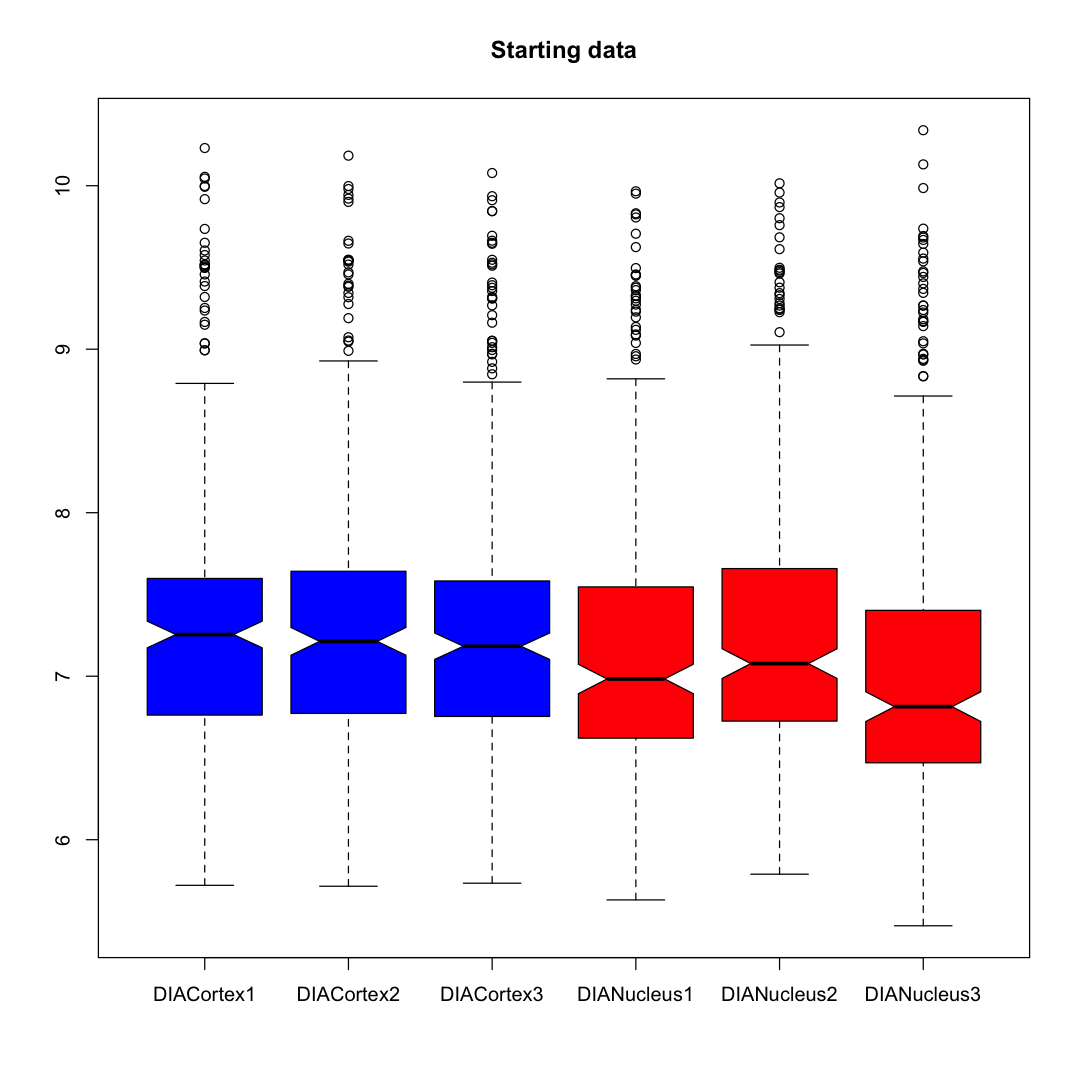

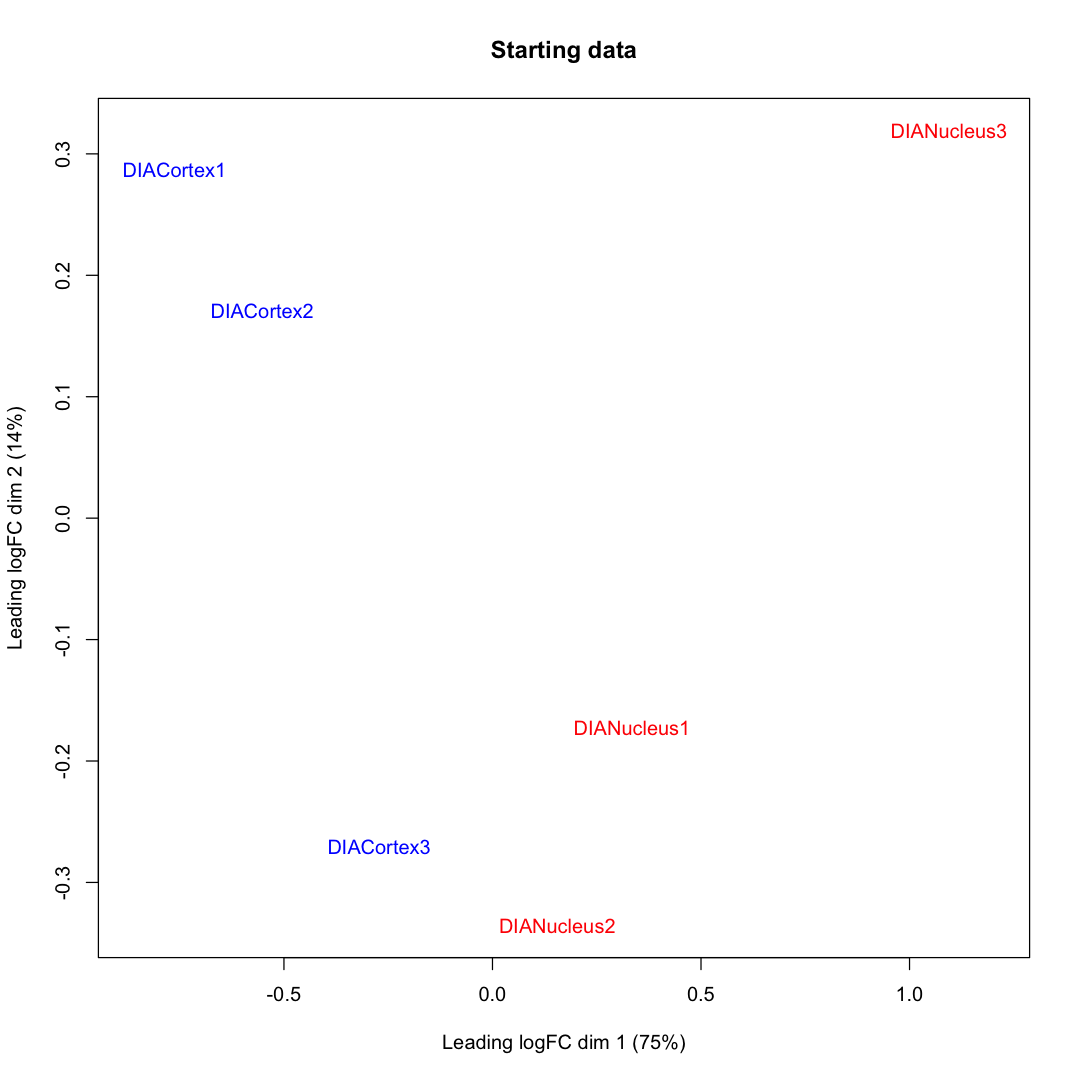

In [5]:
# make plots a little larger
set_plot_dimensions(9, 9)

# plot the starting data
boxplot(log10(dia_data), col = colors_group, notch = TRUE, main = "Starting data")

# check the clustering
plotMDS(log2(dia_data), col = colors_group, main = "Starting data")

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will load the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization to correct for any sample composition differences.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 DIACortex1 -> 0.859293
 DIACortex2 -> 0.922107
 DIACortex3 -> 1.046937
 DIANucleus1 -> 1.189955
 DIANucleus2 -> 1.086005
 DIANucleus3 -> 0.965774

Trimmed mean of M-values (TMM) factors:
 DIACortex1 -> 0.852917
 DIACortex2 -> 0.871935
 DIACortex3 -> 0.862416
 DIANucleus1 -> 0.949726
 DIANucleus2 -> 0.983980
 DIANucleus3 -> 1.668430

Combined (lib size and TMM) normalization factors:
 DIACortex1 -> 0.732906
 DIACortex2 -> 0.804018
 DIACortex3 -> 0.902895
 DIANucleus1 -> 1.130131
 DIANucleus2 -> 1.068607
 DIANucleus3 -> 1.611327


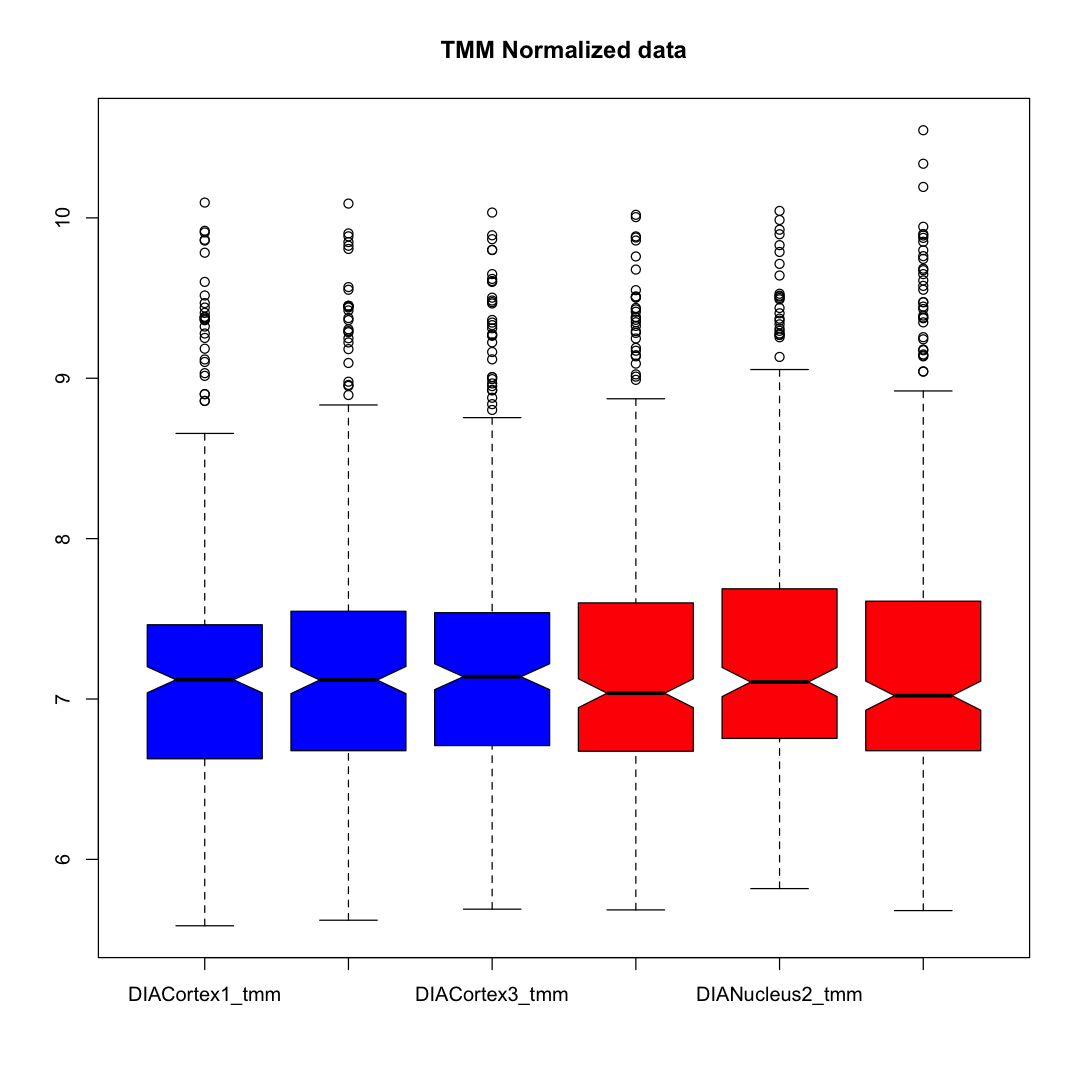

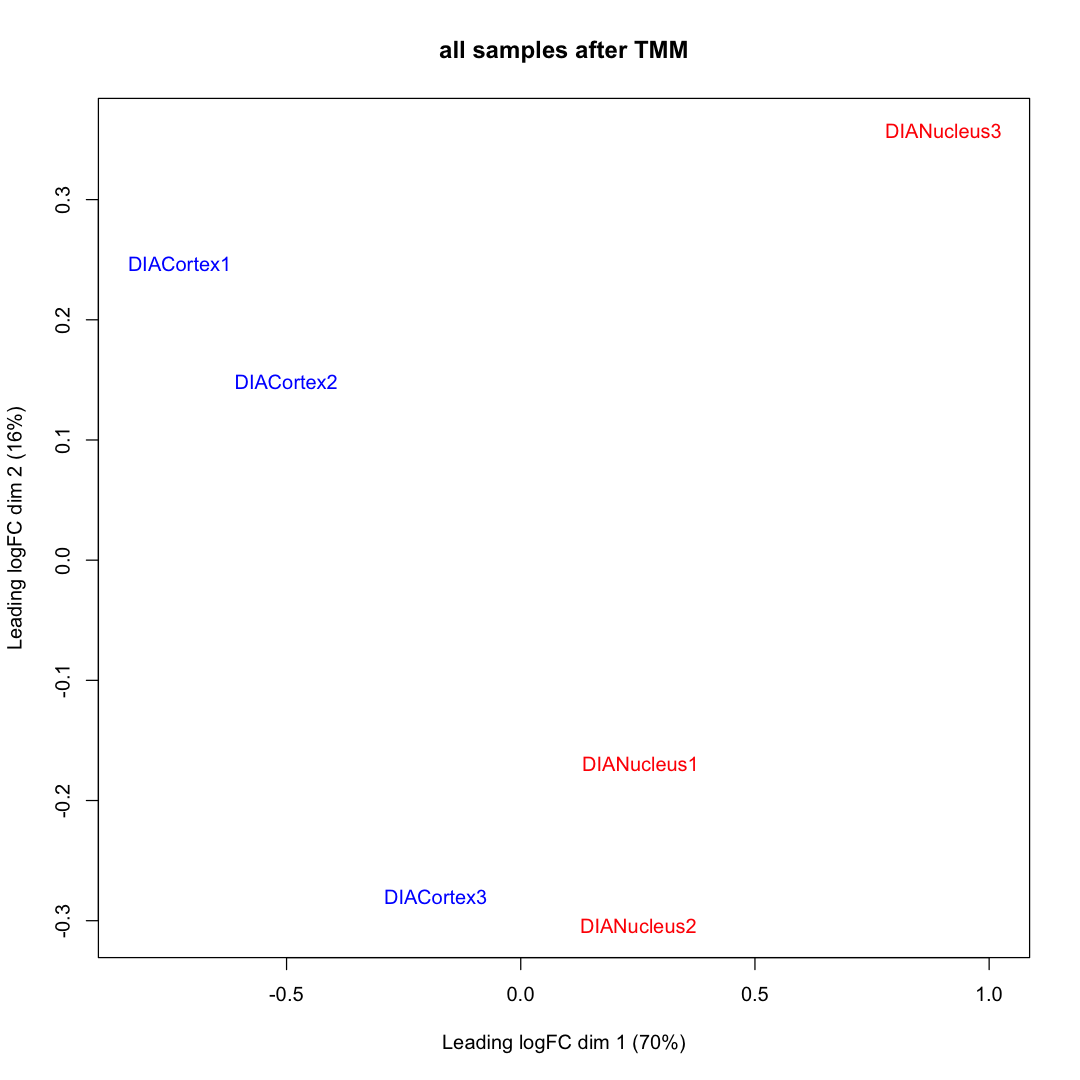

In [6]:
# get the biological sample data into a DGEList object
group = c(rep("cortex", length(cortex)), rep("nucleus", length(nucleus)))

y <- DGEList(counts = dia_data, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# compute the TMM-normalized intensities
dia_tmm <- apply_tmm_factors(y, color = colors_group)

# check the clustering
plotMDS(y, col = colors_group, main = "all samples after TMM")

### TMM factor for `DIANucleus3` not in line with others

Starting box plots look kind of rough for the nucleus samples. Nucleus Rep3 has an okay library factor (total intensity is similar to other samples) but a larger TMM factor. The larger TMM factor means that the composition of Nucleus Rep3 is different. This sample has more intensity for the very highest abundance proteins (crystallins?) that push down the res of the protein intensities. This sample may have less outer nucleus and more inner nucleus with higher crystallin expression.

Box plot horizontal alignment is better after normalization. The clustering looks qualitatively similar before and after TMM normalization. `DIANucleus3` is in the upper right corner. The x-axis is much more important (70% of the variance), so `DIANucleus3` is a possible outlier. However, dropping samples is hard to do in n=3 studies.

## <a name="CVs"></a>Check CV distributions

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This is an effective way to assess proper normalization in these experiments. We will compute CV distributions by group.

In [7]:
# put CVs in data frames to simplify plots and summaries
cv_start <- data.frame(cortex = CV(dia_data[cortex]), nucleus = CV(dia_data[nucleus]))

cv_tmm <- data.frame(cortex = CV(dia_tmm[cortex]), nucleus = CV(dia_tmm[nucleus]))

# see what the median CV values are
medians <- apply(cv_start, 2, FUN = median)
print("Starting median CVs by condition (%)")
round(medians, 2)

medians <- apply(cv_tmm, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

[1] "Starting median CVs by condition (%)"


cortex nucleus 
  20.42   36.23

[1] "Final median CVs by condition (%)"


cortex nucleus 
  18.37   32.48

### Median CVs improve

The CVs for the cortex samples are reasonable and improve a little with TMM normalization. The nucleus samples have a much higher median CV, although it does improve with TMM normalization.

## Use ggplot to visualize the CV distributions

We will just compare the starting data to the final TMM normalized data here.

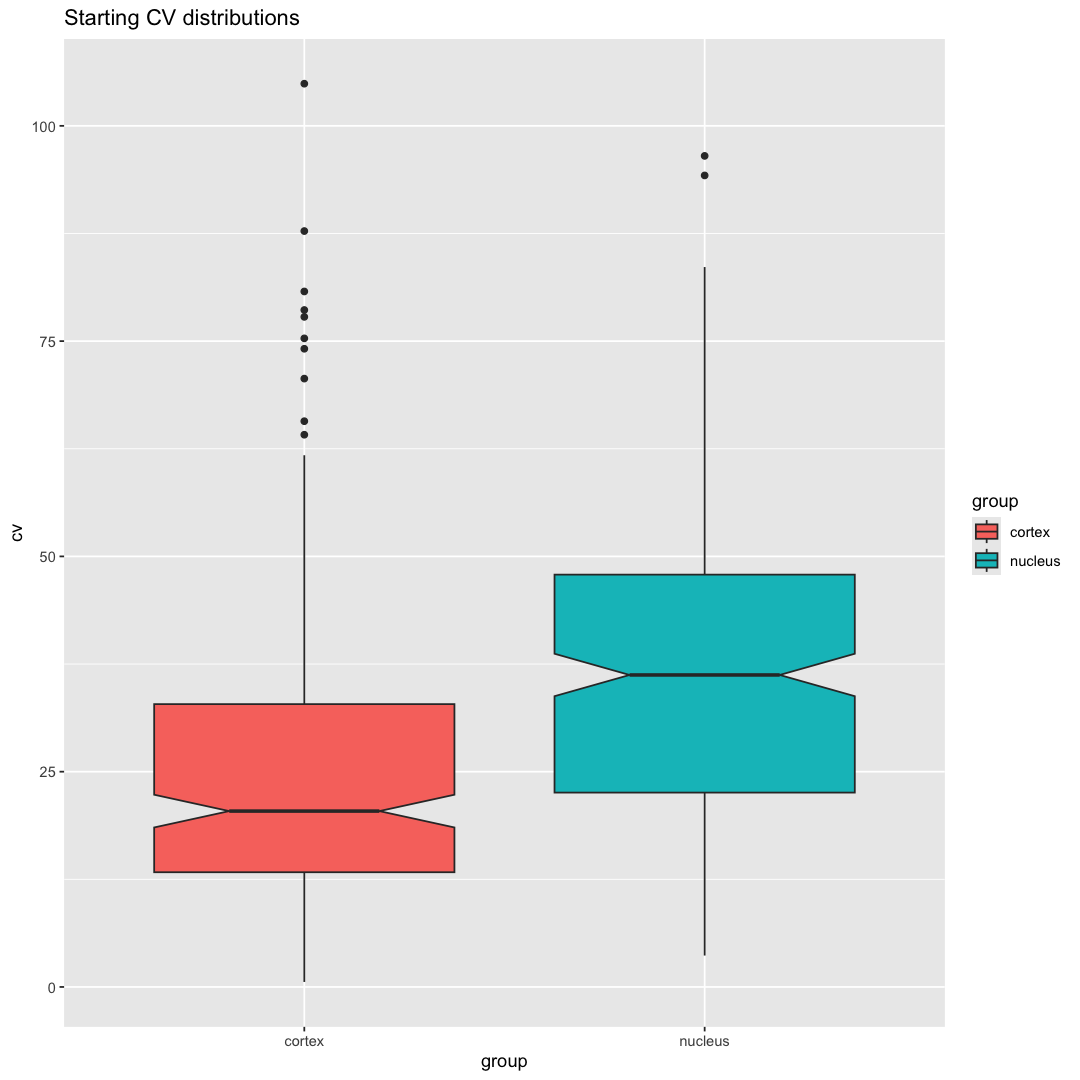

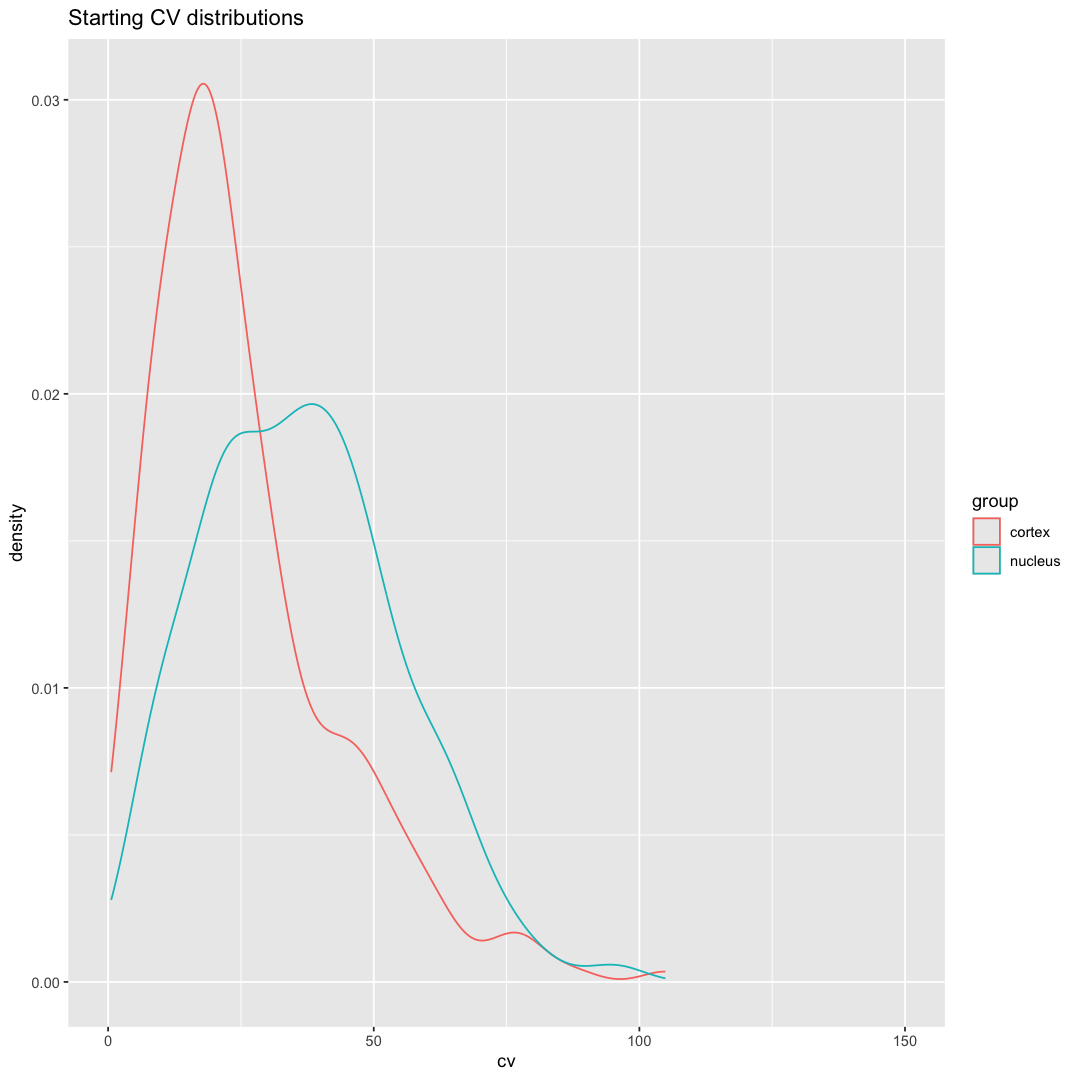

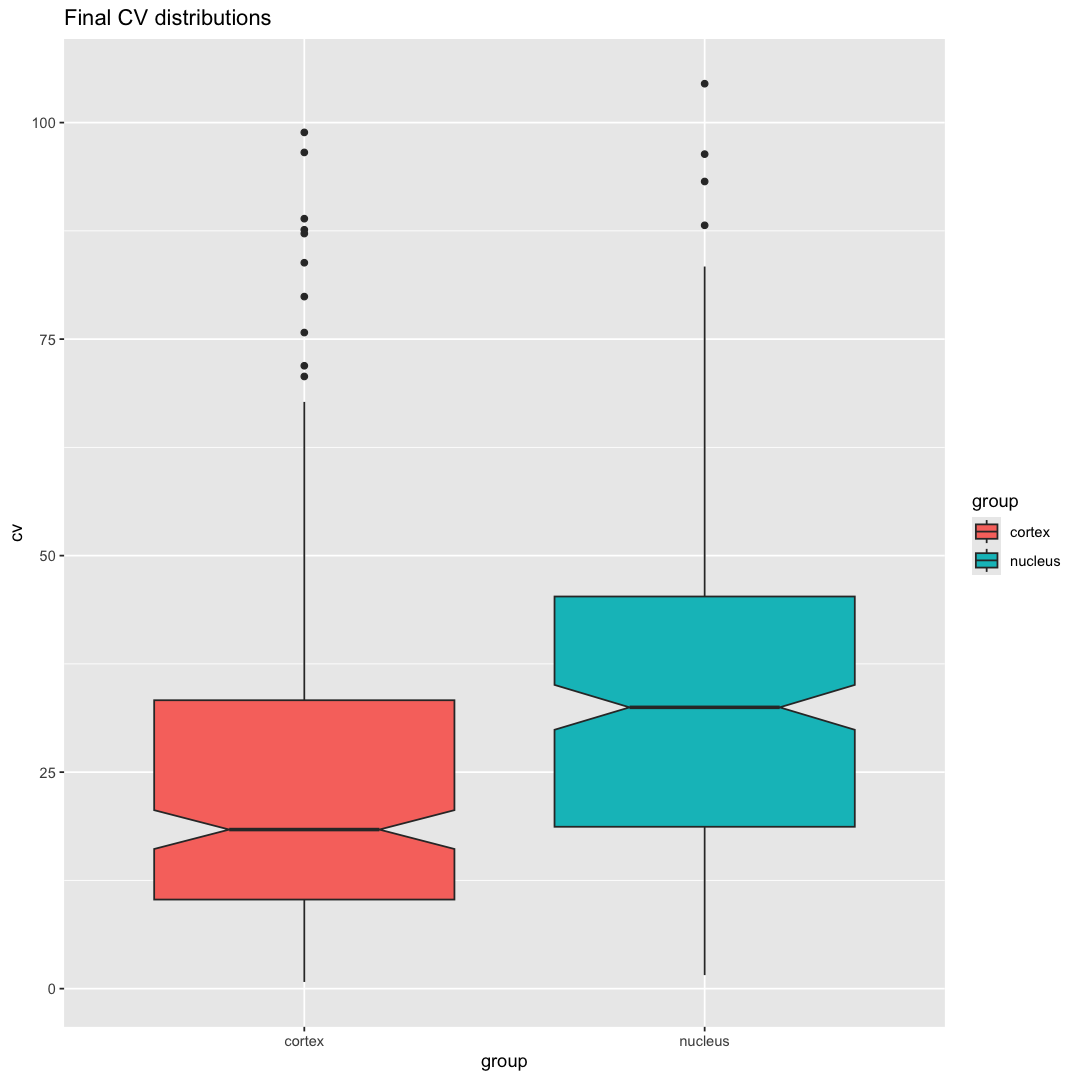

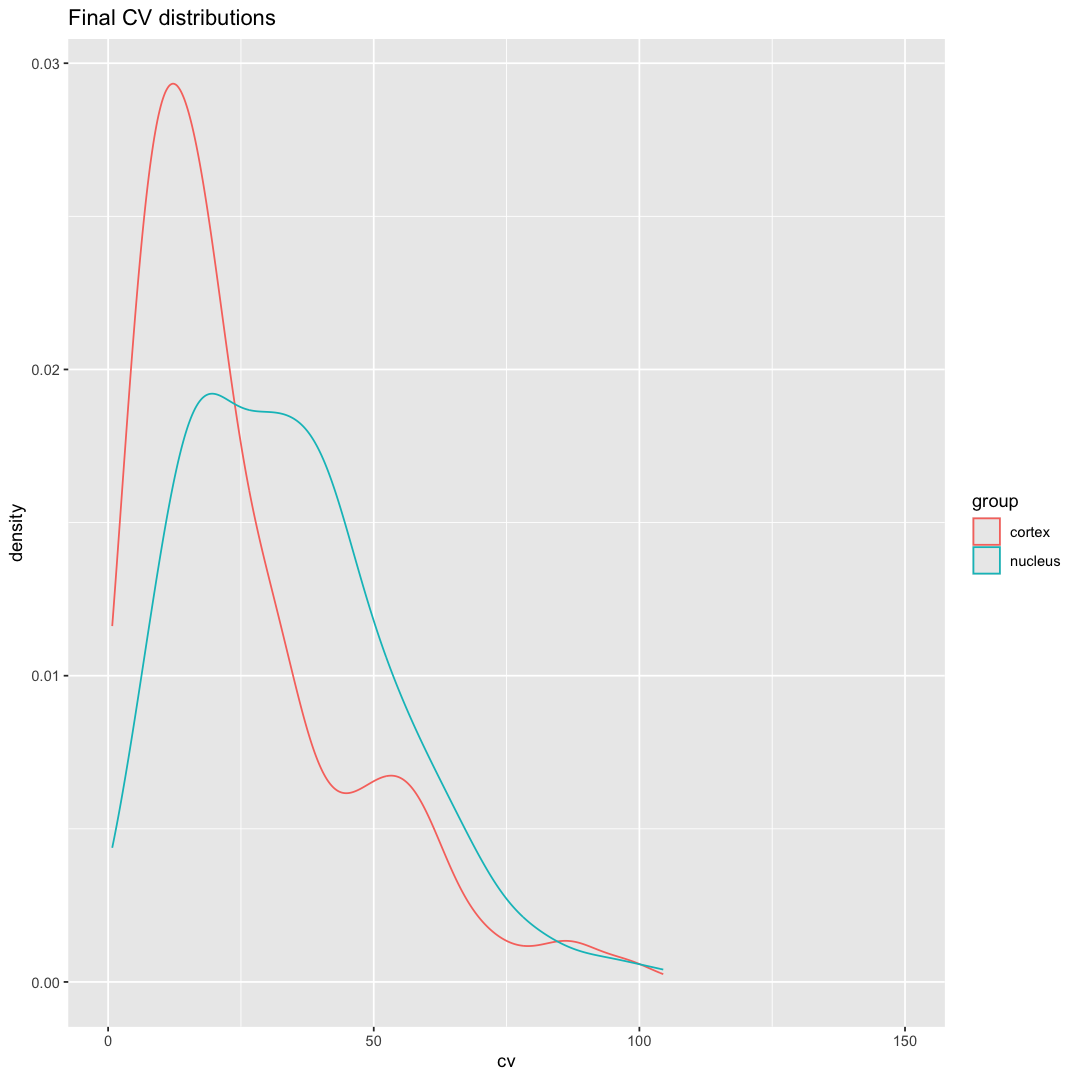

In [8]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv_start <- gather(cv_start, key = "group", value = "cv")

# traditional boxplots
ggplot(long_cv_start, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Starting CV distributions")

# density plots
ggplot(long_cv_start, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 150)) +
  ggtitle("Starting CV distributions")

# need long form for ggplot
long_cv_tmm <- gather(cv_tmm, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_tmm, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Final CV distributions")

# density plots
ggplot(long_cv_tmm, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 150)) +
  ggtitle("Final CV distributions")

### CV distributions are not great

The cortex CV distribution have some structure in the right tail. The nucleus CVs are really broad. This is worse looking than other methods like spectral counting for lens samples. 

## <a name="scatter_plots"></a>Compare samples within each biological condition

We can also look at each biological condition with a multi-panel scatter plot grid and see how similar the biological replicates are to each other. We will use the final TMM-normalized intensities.

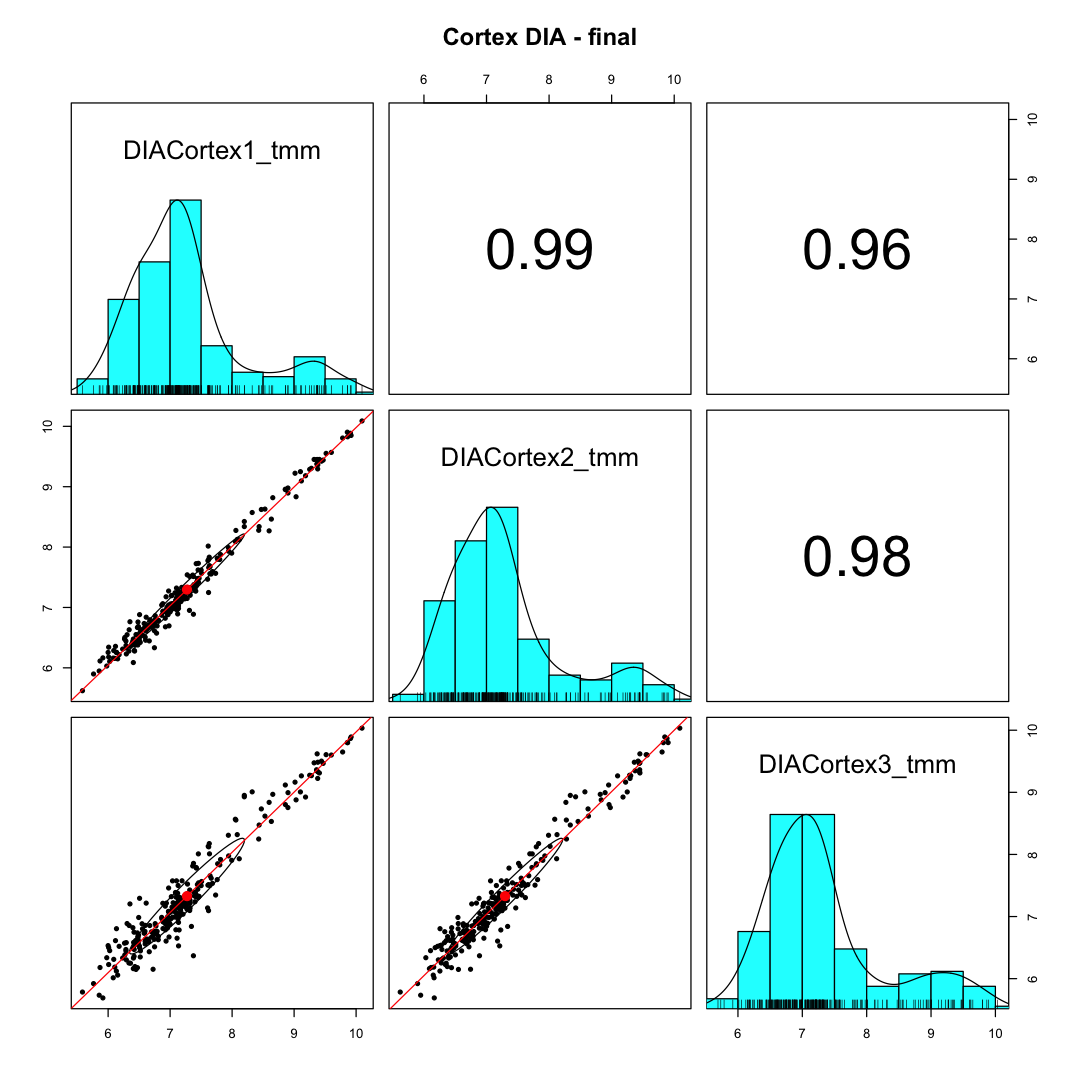

In [9]:
# multi-panel scatter plot grids, final data
pairs.panels(log10(dia_tmm[cortex]), lm = TRUE, main = "Cortex DIA - final")

### There are bimodal intensity distributions for cortex

The diagonal plots in the grids are the density distributions of intensities with a Gaussian kernel density smoothed line. This is the first quant data to give bimodal distributions. It is like there are a handful of higher abundance data (actual quantifiable proteins?) that behaves differently from a larger distribution of low abundance data (noise?).

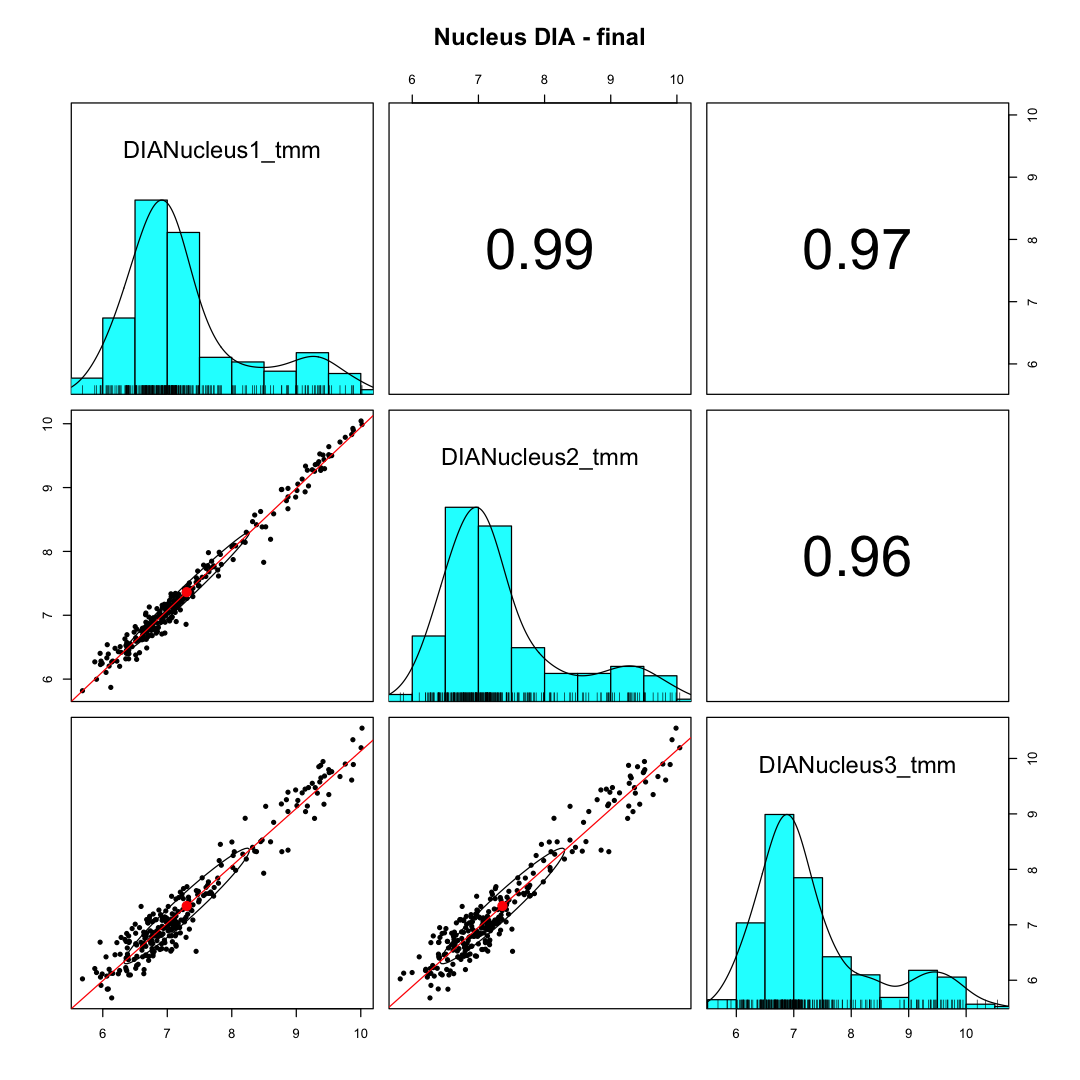

In [10]:
# multi-panel scatter plot grids, final data
pairs.panels(log10(dia_tmm[nucleus]), lm = TRUE, main = "Nucleus DIA - final")

### Nucleus behaves the same way

There are bimodal intensity distributions for the nucleus samples, too. `DIANucleus3` has issues with the high abundance protein intensities.

## Compare averages of each group to each other

We can get a little heads up on the statistical testing by comparing group averages to each other. 

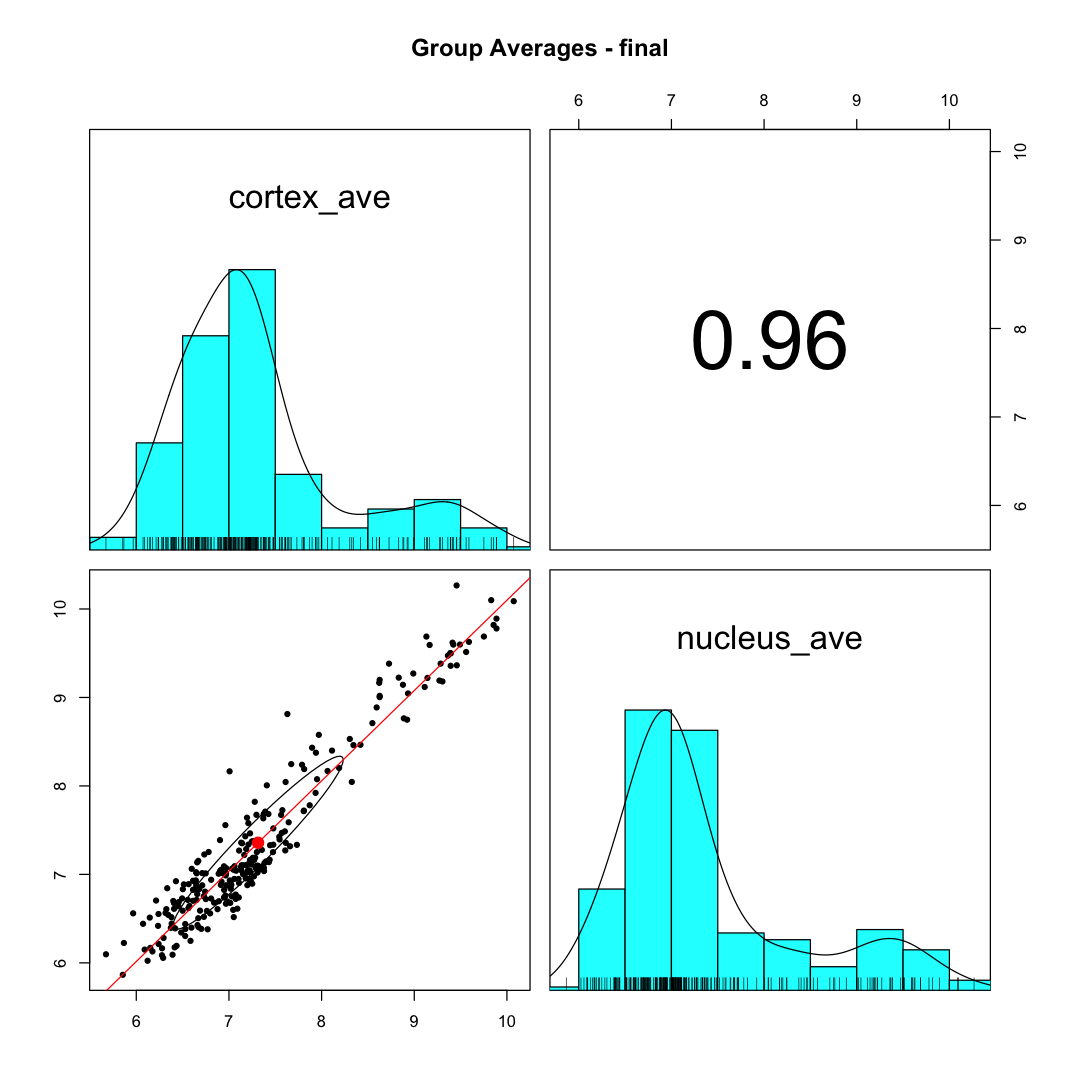

In [11]:
# make a scatter plot grid for the group averages
pairs.panels(log10(cbind(cortex_ave = rowMeans(dia_tmm[cortex]),
                         nucleus_ave = rowMeans(dia_tmm[nucleus]))),
             lm = TRUE, main = "Group Averages - final")

## <a name="summary"></a> Summary

The group averages have an odd-looking scatter plot. The intensity distributions are bimodal. Based on the magnitude of the intensity values, the lower intensity distribution does not seem to be small intensity values, but it is clustering near the lower left and sure looks like noisy data to my eye. Thermo instruments log data with large numerical values based on the calibration mixes. They do not have much to do with how much ion current or how many ions are in the instrument. This is pretty sparse data and seems to have some unusual characteristics not seen in spectral counting or TMT-labeled lens datasets.

## Log the session information

In [12]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-apple-darwin20
Running under: macOS 15.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.4.3     edgeR_4.2.0     limma_3.60.2    scales_1.3.0   
 [5] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [9] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
[13] ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    stringi_1.8.4     lattice_0.22-6   
 [5] hms_1.1.3         digest_0.6.35     magrittr_2.0.3    